# Social media and mental health correlation project



## Mental Health and Social Media - A growing problem


Social media has become an integral part of modern life, revolutionizing communication and connectivity. However, concerns have emerged regarding its potential impact on mental health. This study aims to investigate the relationship between social media usage and mental health outcomes, exploring whether excessive or particular types of social media engagement contribute to increased symptoms of depression, anxiety, and loneliness.

Understanding this relationship is crucial for several reasons. First, social media platforms have become ubiquitous, with a significant proportion of the global population actively engaged. Second, mental health disorders are prevalent worldwide, posing a substantial burden on individuals and society. If social media usage is found to contribute to mental health concerns, targeted interventions and public health strategies can be developed to mitigate these risks. Additionally, understanding the protective factors within social media usage could promote its positive impact on mental well-being.

**The aim of this project is to gain insights into the relationship between social media usage and mental health**

Contents as follows: 
1. Data Source
2. Data Structure
3. Data Cleaning and Transformation
4. Research questions
5. Data visualisation and analysis
6. Conclusions and Summary

## Data source


In this project, I will a preexisting CSV file data provided by a research project for the Statistics Course STA-2101 for the University of Liberal Arts Bangladesh (ULAB). Submitted to - Khan Raqib Mahmud. Submitted by - Souvik Ahmed (203014004) and Muhesena Nasiha Syeda (203014015). 

Found on Kaggle Databases.
kaggle.com

## Data Structure

I have identified my data source and the next step is to import the libraries I need to start exploring the data

In [22]:
#import libraries needed to run analysis and visualise the data
import pandas as pd #data manipultation
import numpy as np #maths stuff
import scipy.stats as stats #stats 
import matplotlib.pyplot as plt #visualisation
import seaborn as sns #visualisation

Next step is to read the file and see what the raw data looks like:

In [23]:
#I've created a separate filepath.py function to record my directory. 
from filepath import filepath
#read the data - "filepath" should be replaced with the directory you store the smmh.csv file on your own device.
rawdata = pd.read_csv(filepath)
rawdata.head()

,Timestamp,1. What is your age?,2. Gender,3. Relationship Status,4. Occupation Status,5. What type of organizations are you affiliated with?,6. Do you use social media?,7. What social media platforms do you commonly use?,8. What is the average time you spend on social media every day?,9. How often do you find yourself using Social media without a specific purpose?,...,11. Do you feel restless if you haven't used Social media in a while?,"12. On a scale of 1 to 5, how easily distracted are you?","13. On a scale of 1 to 5, how much are you bothered by worries?",14. Do you find it difficult to concentrate on things?,"15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?","16. Following the previous question, how do you feel about these comparisons, generally speaking?",17. How often do you look to seek validation from features of social media?,18. How often do you feel depressed or down?,"19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?","20. On a scale of 1 to 5, how often do you face issues regarding sleep?"
0,4/18/2022 19:18:47,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,5,...,2,5,2,5,2,3,2,5,4,5
1,4/18/2022 19:19:28,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,4,...,2,4,5,4,5,1,1,5,4,5
2,4/18/2022 19:25:59,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,3,...,1,2,5,4,3,3,1,4,2,5
3,4/18/2022 19:29:43,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,4,...,1,3,5,3,5,1,2,4,3,2
4,4/18/2022 19:33:31,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,3,...,4,4,5,5,3,3,3,4,4,1


## Data Cleaning and Transformation



### Unecessary columns
Firstly, I don't need the timestamp data, so I'll remove that from the dataset. Then, to create an easy-to-use dataset, I would like to rename all the columns to workable titles and sort the question data into chronological order.

In [24]:
#deleting timestamp column 
notimedata = rawdata.drop(['Timestamp'], axis=1)

#rename the columns for useability. 
#Let's create a new data frame: 
newdata = pd.DataFrame(notimedata)
newdata.columns = ['Age', 'Gender', 'Relationship Status', 
                   'Occupation', 'Affiliations', 
                   'Use Social Media', 'Platforms Used', 'Time Spent', 
                   'Attention Q1', 'Attention Q2', 'Anxiety Q1', 
                   'Attention Q3', 'Anxiety Q2', 'Attention Q4', 
                   'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3', 
                   'Depression Q1', 'Depression Q2', 'Depression Q3'
                   ]


#Checking that the titles are correct
newdata.head()
list(newdata.columns)

#Sorting the data so that the questions are in alphabetical and chronological order
#Create two data frames, one with demographic data (first object) and the other with questions that are sorted by column. 

data = pd.concat([newdata[['Age', 'Gender', 'Relationship Status', 
                   'Occupation', 'Affiliations', 
                   'Use Social Media', 'Platforms Used', 'Time Spent',]], 
                  newdata[['Attention Q1', 'Attention Q2', 'Anxiety Q1', 
                   'Attention Q3', 'Anxiety Q2', 'Attention Q4', 
                   'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3', 
                   'Depression Q1', 'Depression Q2', 'Depression Q3']].sort_index(axis=1)], 
                 ignore_index=False,axis=1)
data.head()
#Just in case, manually check the first entry of the new df to the original raw data to ensure that the scores matched the original dataset. We're all good!

,Age,Gender,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,Attention Q1,Attention Q2,Attention Q3,Attention Q4,Depression Q1,Depression Q2,Depression Q3,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3
0,21.0,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",Between 2 and 3 hours,2,2,5,3,5,5,5,4,5,2,3,2
1,21.0,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",More than 5 hours,2,5,4,3,4,4,5,4,5,5,1,1
2,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",Between 3 and 4 hours,1,5,3,2,2,4,4,2,5,3,3,1
3,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram",More than 5 hours,1,5,4,2,3,3,4,3,2,5,1,2
4,21.0,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",Between 2 and 3 hours,4,5,3,5,4,5,4,4,1,3,3,3


### Finding and filling blank values

Looking for NaNs!

In [25]:
#Finding the rows and columns that have null values.
np.where(pd.isnull(data))

(array([ 17,  24,  42,  47,  63,  64,  74,  80,  85,  97, 108, 128, 162,
        166, 173, 194, 214, 219, 238, 251, 260, 322, 326, 364, 377, 399,
        425, 428, 453, 473]),
 array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4]))

Looks like we have missing values in the 'Affiliations' column. 

Since the rest of the "Affiliations" data is a string, I'm going to replace all the NaNs with 'Unknown'

In [26]:
#Replace NaNs with "Unknown"
data = data.fillna('Unknown')
#Check that we don't have NaNs
np.where(pd.isnull(data))

(array([], dtype=int64), array([], dtype=int64))

### Checking the validity of responses

To make sure that the data shows participants that haven't created odd entries, let's check the responses for the fields that require manual input. Where 'Other' was selected, let's see what people have said. 

In [27]:
#What are the unique values in my dataset and are they super weird / to be excluded?  
for col in data:
    print(data[col].value_counts())

Age
21.0    82
22.0    81
20.0    45
23.0    42
24.0    27
19.0    19
26.0    18
25.0    17
47.0    16
48.0    13
18.0    13
27.0    11
17.0     9
35.0     8
29.0     6
30.0     6
34.0     6
50.0     6
28.0     5
37.0     4
14.0     4
32.0     4
38.0     3
49.0     3
36.0     3
44.0     2
46.0     2
15.0     2
13.0     2
16.0     2
51.0     2
33.0     2
40.0     2
56.0     2
55.0     1
45.0     1
42.0     1
31.0     1
69.0     1
91.0     1
43.0     1
26.7     1
52.0     1
65.0     1
60.0     1
53.0     1
Name: count, dtype: int64
Gender
Female                 263
Male                   211
Nonbinary                1
Non-binary               1
NB                       1
unsure                   1
Trans                    1
Non binary               1
There are others???      1
Name: count, dtype: int64
Relationship Status
Single               285
Married              101
In a relationship     88
Divorced               7
Name: count, dtype: int64
Occupation
University Student    292
Salar

The 'Gender' data needs attention.

Looks like we have two changes to make in the 'Gender' column: 
1. Exclude the participant data that gave the "There are others???" response
2. Change the names of Non-binary entries to have the same format: "Non-binary"

In [28]:
# Dropping the entry "There are others???" entry
data.drop(data.loc[data['Gender']=="There are others???"].index, inplace=True)

#Renaming the indices: Nonbinary, NB, Non binary
data['Gender'].replace(['Nonbinary ', 'NB', 'Non binary ', 'unsure ', 'Trans', 'Non-binary'], 
                    ['Other', 'Other', 'Other', 'Other', 'Other', 'Other'], inplace=True)

#check that it worked
print(data['Gender'].unique())

['Male' 'Female' 'Other']


The 'Age' column is a float. So let's convert that.

In [29]:
#convert float to int
data['Age'] = data['Age'].astype(int)

#check
display(data['Age'].dtypes)

dtype('int64')

### Making our data more readable

1. The "Time Spent" on social media values are long. 
2. It'd also be helpful to create a new column for "Time Spent" that's an integer of the mean time spent for further analysis and modelling later.


In [30]:
#Create more readable values
data['Time Spent'].replace(['Between 2 and 3 hours', 'More than 5 hours', 'Between 3 and 4 hours',
 'Less than an Hour', 'Between 1 and 2 hours', 'Between 4 and 5 hours'], 
                           ['2-3 hours', '>5 hours', '3-4 hours', '<1 hour', '1-2 hours', '4-5 hours'], 
                           inplace=True)

#check 
print(data['Time Spent'].unique())

#Create a column of time spent as an integer.
#Specify conditions for our new time values to be assigned.
conditions = [
    (data['Time Spent'] == '<1 hour'),
    (data['Time Spent'] == '1-2 hours'),
    (data['Time Spent'] == '2-3 hours'),
    (data['Time Spent'] == '3-4 hours'), 
    (data['Time Spent'] == '4-5 hours'), 
    (data['Time Spent'] == '>5 hours'), 
]
     
#Creating time values using the upper bounds of the range given (to avoid using 0 on the <1 values)
time_values = [1, 2, 3, 4, 5, 6]

#Create a new column for Time Spent with our new values for each categorical time slot.
data['Time (hrs)'] = np.select(conditions, time_values)
data.head()

#Check that no weird values have popped up
print(data['Time (hrs)'].unique())


['2-3 hours' '>5 hours' '3-4 hours' '<1 hour' '1-2 hours' '4-5 hours']
[3 6 4 1 2 5]


### Platforms used

Does the number of social media platforms used affect mental health scores? 

Assuming that the more time we spend on social media, the more likely we are to use other platforms. 

To find out if there's a relationship there, we need to first create a column for the number of platforms the participants use:

In [31]:
#Creating a new column 'platform count' where we are counting the platforms used, 
#by using a function that splits the strings within the column.
data['Platform Count'] = data['Platforms Used'].apply(lambda x: len(x.split()))
data.head()

,Age,Gender,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,...,Attention Q3,Attention Q4,Depression Q1,Depression Q2,Depression Q3,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3,Time (hrs),Platform Count
0,21,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",2-3 hours,2,2,...,5,5,5,4,5,2,3,2,3,6
1,21,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",>5 hours,2,5,...,4,4,5,4,5,5,1,1,6,6
2,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",3-4 hours,1,5,...,2,4,4,2,5,3,3,1,4,4
3,21,Female,Single,University Student,University,Yes,"Facebook, Instagram",>5 hours,1,5,...,3,3,4,3,2,5,1,2,6,2
4,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",2-3 hours,4,5,...,4,5,4,4,1,3,3,3,3,3


### Mental Health Scoring

We have multiple changes to make to our mental health scoring data:

1. One mental health questionnaire needs to be tranformed to reflect an accurate mental health score. 
2. Creating total questionnaire scores
3. Creating a total (overall) mental health score from all the questionnaires
4. Adding a mental health score "Outcome" column which will indicate whether a participant is experiencing severe mental health symptoms or not.

**Self esteem Question 2**

Our assumption is that higher scores indicate negatively affected mental health. Self esteem question 2 works in reverse, where higher scores are associated with positive mental health. So, we need to convert this question so that the numbers, when summed to a total mental health score, accurately represent that a high score indicates negative effects on mental health. 

The default score is as follows: 
- Very Negative - 1
- Slightly Negative - 2
- Neutral - 3 
- Slightly Positive - 4
- Very positive - 5


To create an accurate depiction of the effect of social media on mental health, including any positive effects, I will simply reverse the scoring, as seen below: 
- Very Negative - 5
- Slightly Negative - 4
- Neutral - 3 
- Slightly Positive - 2
- Very positive - 1

In [32]:
#Create conditions again

selfesteem_conditions = [
    (data['Self Esteem Q2'] == 1), 
    (data['Self Esteem Q2'] == 2), 
    (data['Self Esteem Q2'] == 3), 
    (data['Self Esteem Q2'] == 4), 
    (data['Self Esteem Q2'] == 5)
]

new_esteem_values = [5, 4, 3, 2, 1]

#assign new values in the self esteem column
data['Self Esteem Q2'] = np.select(selfesteem_conditions, new_esteem_values)
data.head()

,Age,Gender,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,...,Attention Q3,Attention Q4,Depression Q1,Depression Q2,Depression Q3,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3,Time (hrs),Platform Count
0,21,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",2-3 hours,2,2,...,5,5,5,4,5,2,3,2,3,6
1,21,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",>5 hours,2,5,...,4,4,5,4,5,5,5,1,6,6
2,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",3-4 hours,1,5,...,2,4,4,2,5,3,3,1,4,4
3,21,Female,Single,University Student,University,Yes,"Facebook, Instagram",>5 hours,1,5,...,3,3,4,3,2,5,5,2,6,2
4,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",2-3 hours,4,5,...,4,5,4,4,1,3,3,3,3,3


**Total Scores for Mental Health**

To find out broadly how social media affects mental well being, let's get a total score from all the questionnaires. To dig deeper into potential interactions of mental health with each category (depression, attention, self-esteem), let's create new columns for these separate totals, too.

In [33]:
#Summing anxiety scores
data['Anxiety Score'] = data['Anxiety Q1'] + data['Anxiety Q2'] 

#Sum attention scores
data['Attention Score'] = data['Attention Q1'] + data['Attention Q2'] + data['Attention Q3'] + data['Attention Q4']

#Sum Depression Scores 
data['Depression Score'] = data['Depression Q1'] + data['Depression Q2'] + data['Depression Q3']

#Sum Self Esteem Scores 
data['Self Esteem Score'] = data['Self Esteem Q1'] + data['Self Esteem Q2'] + data['Self Esteem Q3']

#Total mental health score 
data['Total Score'] = data['Self Esteem Score'] + data['Depression Score'] + data['Attention Score'] + data['Anxiety Score']

#See the scores
data.head()

,Age,Gender,Relationship Status,Occupation,Affiliations,Use Social Media,Platforms Used,Time Spent,Anxiety Q1,Anxiety Q2,...,Self Esteem Q1,Self Esteem Q2,Self Esteem Q3,Time (hrs),Platform Count,Anxiety Score,Attention Score,Depression Score,Self Esteem Score,Total Score
0,21,Male,In a relationship,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",2-3 hours,2,2,...,2,3,2,3,6,4,18,14,7,43
1,21,Female,Single,University Student,University,Yes,"Facebook, Twitter, Instagram, YouTube, Discord...",>5 hours,2,5,...,5,5,1,6,6,7,15,14,11,47
2,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube, Pinterest",3-4 hours,1,5,...,3,3,1,4,4,6,11,11,7,35
3,21,Female,Single,University Student,University,Yes,"Facebook, Instagram",>5 hours,1,5,...,5,5,2,6,2,6,12,9,12,39
4,21,Female,Single,University Student,University,Yes,"Facebook, Instagram, YouTube",2-3 hours,4,5,...,3,3,3,3,3,9,17,9,9,44


**Mental Health Outcomes**

A total mental health score exceeding 40 likely indicates that the participant is experiencing severe mental health symptoms. Outcomes can also be very useful for classifying whether a dataset is likely to belong to someone experiencing mental health symptoms. This way, we can predict outcomes based on the features of our data.

Any score below 40 is deemed as not experiencing severe mental health symptoms, and will be given the value "0". Any score above 40 will be given the score "1", where severe mental health symptoms are being subjectively experienced by the participant.

In [34]:
#Any total score below 40 is 0, and total scores above 40 will be 1. 
def outcome_score(score): 
    if score >= 40: 
        return 1
    else: 
        return 0

data['Outcome'] = data['Total Score'].apply(lambda score: outcome_score(score))

#let's check that it worked - the sum of "True" in outcome and Total Score should be the same.
print(sum(data['Outcome'] == 1))
print(sum(data['Total Score'] >= 40))
#We also should not have any unique values.
print(data['Outcome'].value_counts())

219
219
Outcome
0    261
1    219
Name: count, dtype: int64


### Outliers

Checking for outliers is an important criteria for us to meet if we want to conduct correlation analyses. Any outliers in our data will be excluded from the dataset. 

In [35]:
#Let's check for outliers in our age, time spent, and total mental health scores. 
print(data.describe())
#preliminarily, age looks like it has a few outliers with a max value of 91.

#Below is a function to check our columns for outliers.
def outlier_calc(column):
    q1 = np.percentile(column, 25) 
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    threshold = 1.5 * iqr
    outliers = np.where((column < q1 - threshold) | (column > q3 + threshold))
    return outliers[0]

indices = outlier_calc(data['Age'])
print(indices)

              Age  Anxiety Q1  Anxiety Q2  Attention Q1  Attention Q2  \
count  480.000000  480.000000  480.000000    480.000000    480.000000   
mean    26.143750    2.583333    3.564583      3.552083      3.316667   
std      9.923621    1.253527    1.279351      1.097252      1.327300   
min     13.000000    1.000000    1.000000      1.000000      1.000000   
25%     21.000000    2.000000    3.000000      3.000000      2.000000   
50%     22.000000    2.000000    4.000000      4.000000      3.000000   
75%     26.000000    3.000000    5.000000      4.000000      4.000000   
max     91.000000    5.000000    5.000000      5.000000      5.000000   

       Attention Q3  Attention Q4  Depression Q1  Depression Q2  \
count    480.000000    480.000000     480.000000     480.000000   
mean       3.345833      3.245833       3.260417       3.172917   
std        1.174353      1.348464       1.310347       1.256838   
min        1.000000      1.000000       1.000000       1.000000   
25%    

Looks like we have a few outliers in our age variable. Time to remove those data points so it doesn't affect our linear regression model or data analysis. 

In [36]:
#dropping the indices that have outliers.
data.drop(labels=indices, inplace=True)
#check the Age statistics, and we can see that the max age is now 53.
data.describe()

,Age,Anxiety Q1,Anxiety Q2,Attention Q1,Attention Q2,Attention Q3,Attention Q4,Depression Q1,Depression Q2,Depression Q3,...,Self Esteem Q2,Self Esteem Q3,Time (hrs),Platform Count,Anxiety Score,Attention Score,Depression Score,Self Esteem Score,Total Score,Outcome
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,...,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,22.608586,2.684343,3.732323,3.648990,3.464646,3.472222,3.424242,3.449495,3.297980,3.328283,...,3.257576,2.500000,4.154040,4.507576,6.416667,14.010101,10.075758,8.686869,39.189394,0.517677
std,4.482972,1.262450,1.223841,1.046041,1.277364,1.139281,1.287454,1.254854,1.229221,1.443732,...,1.059887,1.253855,1.505772,1.959706,1.993820,3.703560,2.905136,2.459377,8.501794,0.500320
min,13.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,3.000000,3.000000,16.000000,0.000000
25%,21.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,2.000000,...,3.000000,1.000000,3.000000,3.000000,5.000000,11.000000,8.000000,7.000000,33.750000,0.000000
50%,22.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,3.000000,4.000000,...,3.000000,2.500000,4.000000,4.000000,6.000000,14.000000,10.000000,9.000000,40.000000,1.000000
75%,24.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,...,4.000000,3.250000,6.000000,6.000000,8.000000,17.000000,12.000000,10.000000,45.000000,1.000000
max,53.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,6.000000,9.000000,10.000000,20.000000,15.000000,15.000000,59.000000,1.000000


Has this transformed our data? let's check how this has affected the demographic readings

In [37]:
for col in data:
    print(data[col].value_counts())

Age
21    80
22    79
20    44
23    42
24    27
26    18
25    17
19    17
18    13
27    11
17     9
30     6
29     6
28     4
32     4
14     3
16     2
15     2
33     2
35     2
13     2
31     1
52     1
44     1
51     1
50     1
53     1
Name: count, dtype: int64
Gender
Female    228
Male      163
Other       5
Name: count, dtype: int64
Relationship Status
Single               271
In a relationship     86
Married               38
Divorced               1
Name: count, dtype: int64
Occupation
University Student    285
Salaried Worker        61
School Student         48
Retired                 2
Name: count, dtype: int64
Affiliations
University                        226
Private                            32
School                             32
Unknown                            23
University, Company                18
Company                            17
University, Private                15
School, University                  8
University, Company, Private        5
School, Un

Seems like there's only one divorced person in our dataset. To simplify our analysis, we'll put this data point into the 'single' category

In [38]:
data.loc[data['Relationship Status'] == 'Divorced', 'Relationship Status'] = 'Single'

# Research Questions 

Does social media usage affect mental health outcomes and if so, can we predict outcomes based on demographic data and social media habits?

To answer these questions, we'll take a step-by-step approach, testing each assumption of our question, namely: 

1. What is our demographic data? Are there defining features that are more likely to affect mental health or social media habits?
2. How does social media usage, mental health scores and outcomes differ across the demographics? 
3. What relationships exist between our demographic, mental health scores & outcomes, and social media usage? Are there any defining predictors for mental health outcomes? 
4. Which model would best predict mental health outcomes? 

## Demographic data
In this section, we'll explore how each of our variables are distributed and whether they are normal. After all, a Pearson correlation test wouldn't be happy with non-normal data. 

Firstly, for standardisation, I'm setting a theme for the visualiations.

In [39]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

#Set the theme and make stuff look good
sns.set_theme()

### Age

A histogram would be able to tell us how our age data is distibuted. 

For our correlations later, we'll be using a Pearson's correlation test. To do this, we need normally distributed samples and for this, I've used a Shapiro Wilkes test. 

the p-value of the Shapiro-Wilkes test is 1.279525880166013e-24


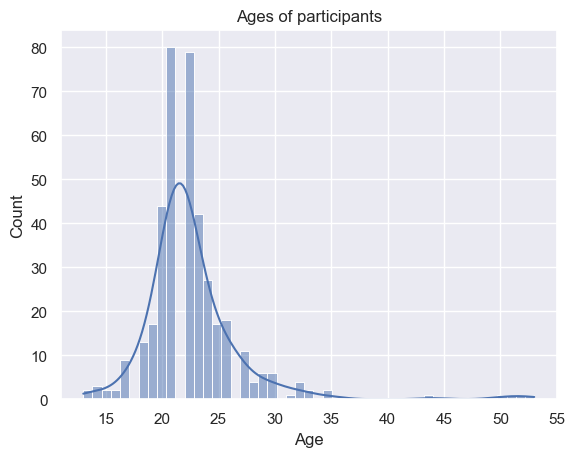

In [40]:
#Create a histogram
sns.histplot(data=data, x=data['Age'], kde=True).set(
    title='Ages of participants')

#Do a Shapiro-Wilkes test to check for normality of the Age distribution
res = stats.shapiro(data['Age'])
#p value < 0.05 indicates that the distribution is normal
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

### Distribution of Gender, Occupation and Relationship Status

... Using pie charts.

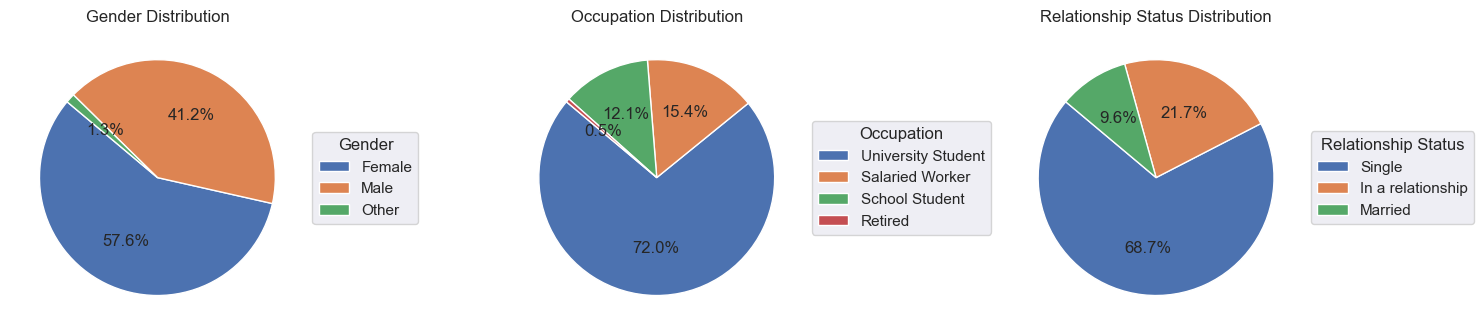

In [41]:
# Plot 1: Pie Chart for 'Gender'
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
gender_counts = data['Gender'].value_counts()
plt.pie(gender_counts, autopct='%1.1f%%', startangle=140)
plt.legend(gender_counts.index, 
           title="Gender", 
           loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Gender Distribution")

# Plot 2: Pie Chart for 'Occupation'
plt.subplot(1, 3, 2)
job_counts = data['Occupation'].value_counts()
plt.pie(job_counts, autopct='%1.1f%%', startangle=140)
plt.legend(job_counts.index, 
           title="Occupation", 
           loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Occupation Distribution")

# Plot 3: Pie chart for 'relationship_status'
plt.subplot(1, 3, 3)
rel_counts = data['Relationship Status'].value_counts()
plt.pie(rel_counts, autopct='%1.1f%%', startangle=140)
plt.legend(rel_counts.index, 
           title="Relationship Status", 
           loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Relationship Status Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Social Media Usage

To determine social media usage or social media habits, we have two metrics: 

1. Time spent on social media in hours
2. Number of platforms used

The first step is to see how these are distributed overall, and then by demographic.

### Time Spent on Social Media

the p-value of the Shapiro-Wilkes test is 1.6550616154743162e-15


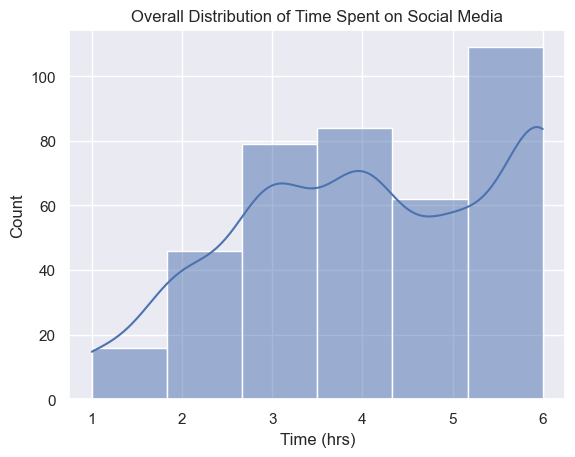

In [43]:
#Checking the overall distribution of time spent on social media
sns.histplot(data=data, x=data['Time (hrs)'], bins=6, kde=True).set(
    title='Overall Distribution of Time Spent on Social Media')

#Shapiro wilkes test 
res = stats.shapiro(data['Time (hrs)'])
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

How does time spent on social media differ across our demographics, ie: Age, Gender, Relationship Status and Occupation?

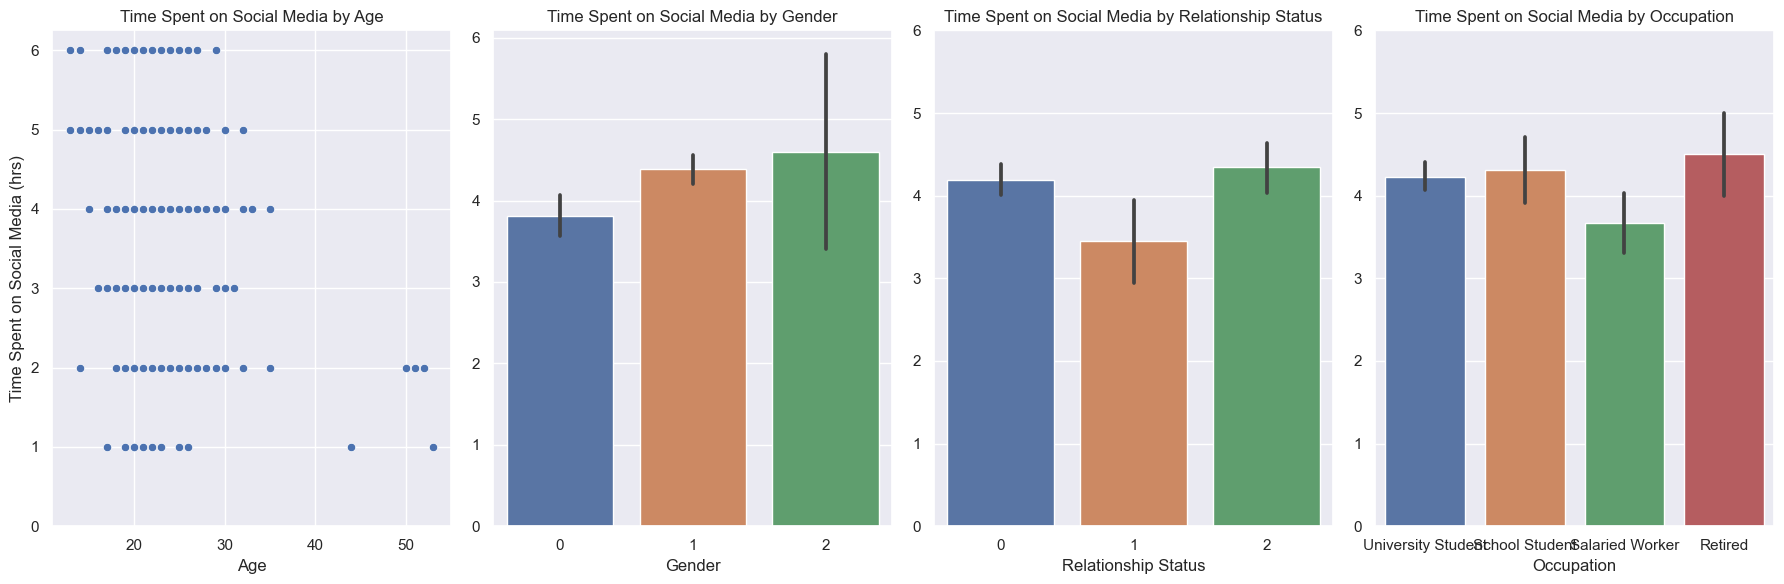

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Subplot 1: Time spent on social media across different age groups
sns.scatterplot(x=data['Age'], y=data['Time (hrs)'], data=data, ax=axes[0]).set(
    title ='Time Spent on Social Media by Age', 
    ylabel='Time Spent on Social Media (hrs)', yticks=range(7))

# Subplot 2: Time spent on social media across different genders
sns.barplot(x=data['Gender'], y=data['Time (hrs)'], data=data, ax=axes[1]).set(
    title='Time Spent on Social Media by Gender',
    ylabel=None, yticks=range(7))

# Subplot 3: Time spent on social media across different relationship statuses
sns.barplot(x=data['Relationship Status'], y=data['Time (hrs)'], data=data, ax=axes[2]).set(
    title ='Time Spent on Social Media by Relationship Status', 
    ylabel=None, yticks=range(7))

# Subplot 4: Time spent on social media across different occupations
sns.barplot(x=data['Occupation'], y=data['Time (hrs)'], data=data, ax=axes[3]).set(
    title ='Time Spent on Social Media by Occupation', 
    ylabel=None, yticks=range(7))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Number of platforms

the p-value of the Shapiro-Wilkes test is 2.0444774762040652e-08


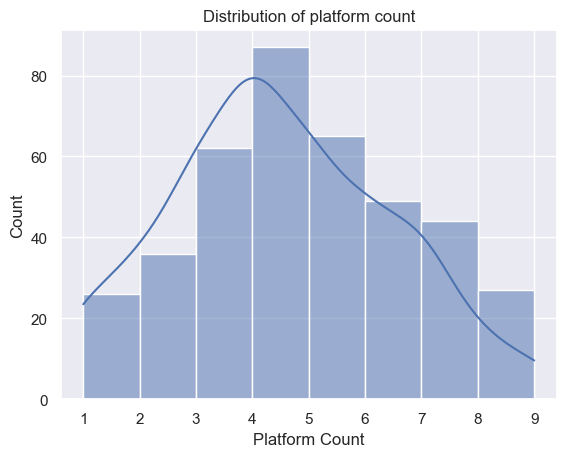

In [45]:
#Distribution of platform count
sns.histplot(data=data, x=data['Platform Count'], bins=8, kde=True).set(
    title='Distribution of platform count')

#Shapiro wilkes test 
res = stats.shapiro(data['Platform Count'])
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

Number of platforms used by demographic

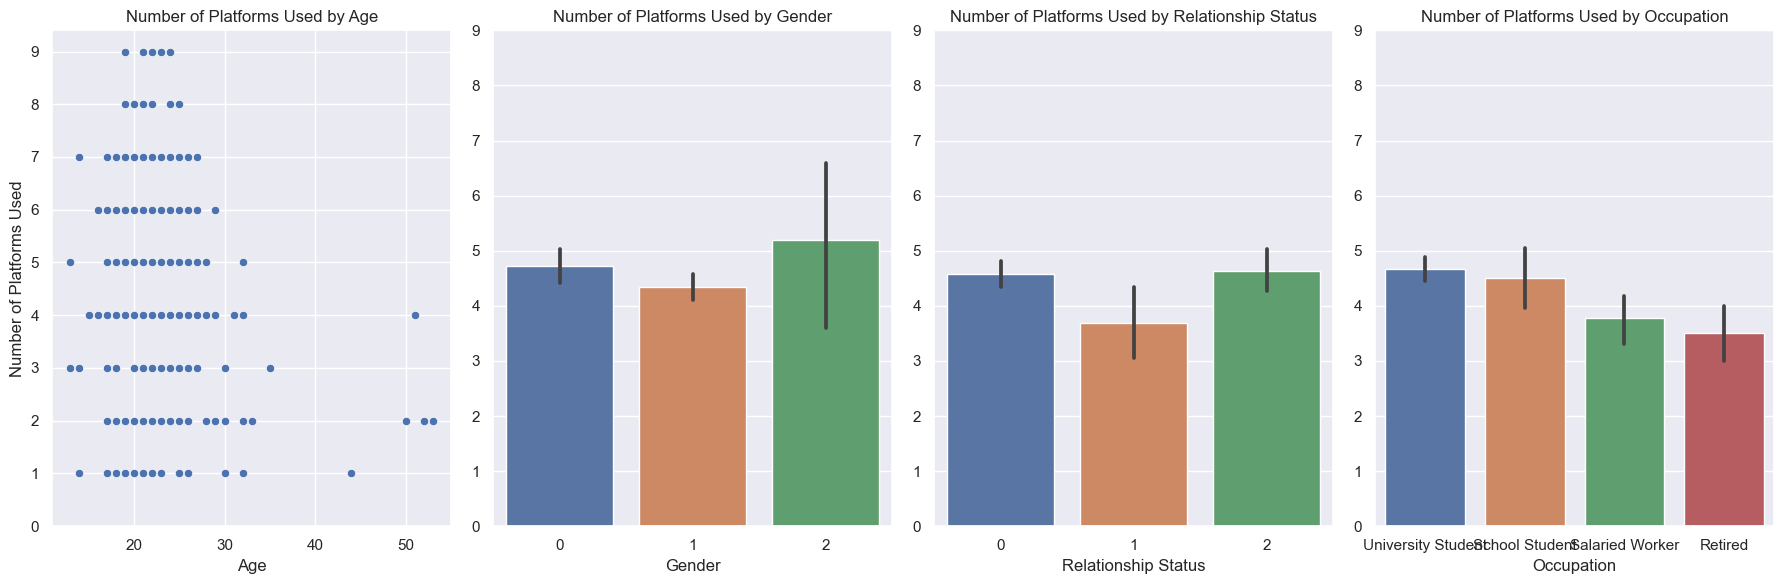

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Subplot 1: # of platforms on social media across different age groups
sns.scatterplot(x=data['Age'], y=data['Platform Count'], data=data, ax=axes[0]).set(
    title ='Number of Platforms Used by Age', 
    ylabel='Number of Platforms Used', yticks=range(10))

# Subplot 2: # of platforms on social media across different genders
sns.barplot(x=data['Gender'], y=data['Platform Count'], data=data, ax=axes[1]).set(
    title ='Number of Platforms Used by Gender', 
    ylabel=None, yticks=range(10))

# Subplot 3: # of platforms on social media across different relationship statuses
sns.barplot(x=data['Relationship Status'], y=data['Platform Count'], data=data, ax=axes[2]).set(
    title ='Number of Platforms Used by Relationship Status', 
    ylabel=None, yticks=range(10))

sns.barplot(x=data['Occupation'], y=data['Platform Count'], data=data, ax=axes[3]).set(
    title ='Number of Platforms Used by Occupation', 
    ylabel=None, yticks=range(10))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Mental Health Scores & Outcomes

Next up, let's see how the mental health scores are distributed in our sample of total participants.

### Total Mental Health Scores

the p-value of the Shapiro-Wilkes test is 0.0023971861228346825


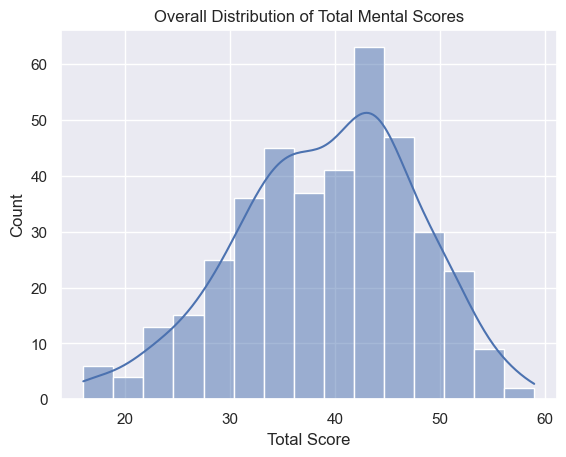

In [47]:
#Now, mental health scores:
sns.histplot(data=data, x=data['Total Score'], kde=True).set(
    title='Overall Distribution of Total Mental Scores') #graph looks normal.

#Shapiro wilkes test 
res = stats.shapiro(data['Total Score'])
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

Mental health scores by demographic

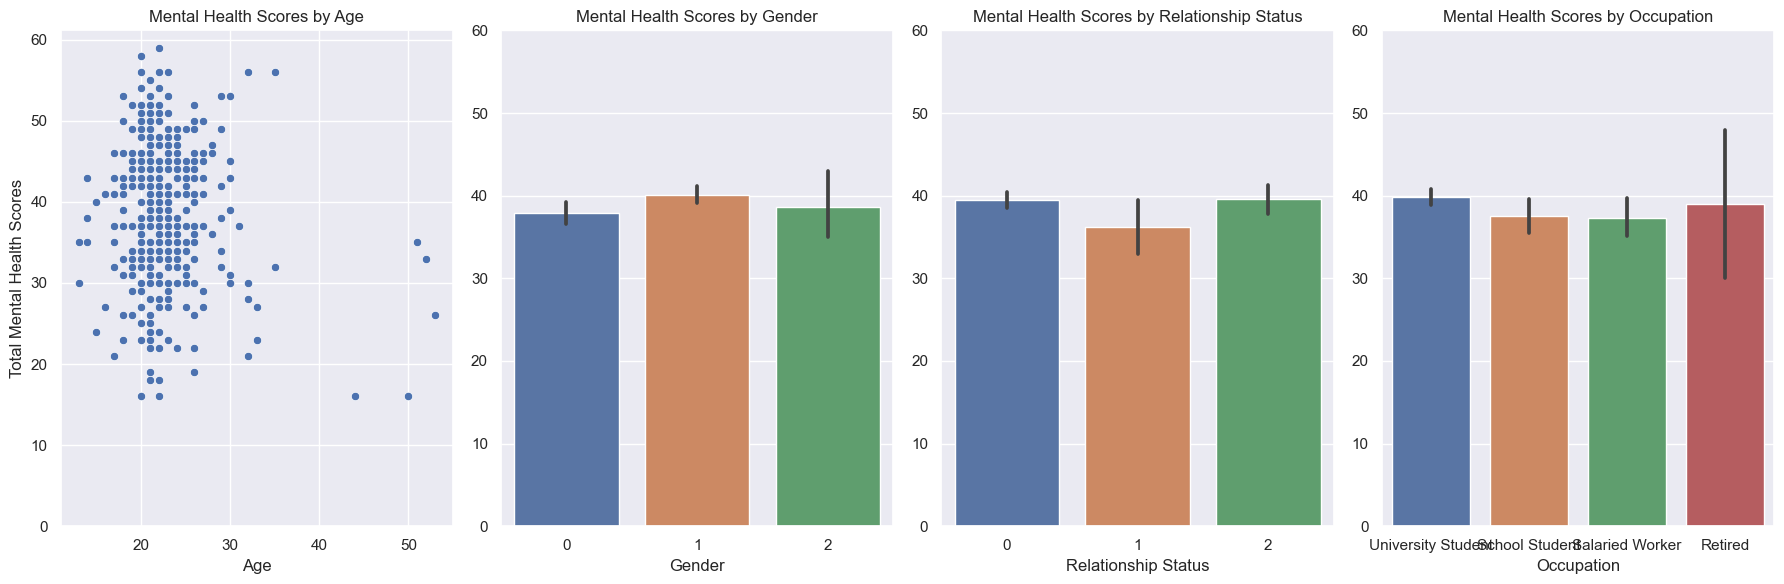

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6))

# Subplot 1: total mental health scores across different age groups
sns.scatterplot(x=data['Age'], y=data['Total Score'], data=data, ax=axes[0]).set(
    title ='Mental Health Scores by Age', 
    ylabel='Total Mental Health Scores', yticks=range(0,70,10))

# Subplot 2: total mental health scores across different genders
sns.barplot(x=data['Gender'], y=data['Total Score'], data=data, ax=axes[1]).set(
    title ='Mental Health Scores by Gender', 
    ylabel=None, yticks=range(0,70,10))

# Subplot 3: total mental health scores across different relationship statuses
sns.barplot(x=data['Relationship Status'], 
             y=data['Total Score'], data=data, ax=axes[2]).set(
    title ='Mental Health Scores by Relationship Status', 
    ylabel=None, yticks=range(0,70,10))

# Subplot 3: total mental health scores across different occupations
sns.barplot(x=data['Occupation'], 
             y=data['Total Score'], data=data, ax=axes[3]).set(
    title ='Mental Health Scores by Occupation', 
    ylabel=None, yticks=range(0,70,10))

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Mental Health Outcomes

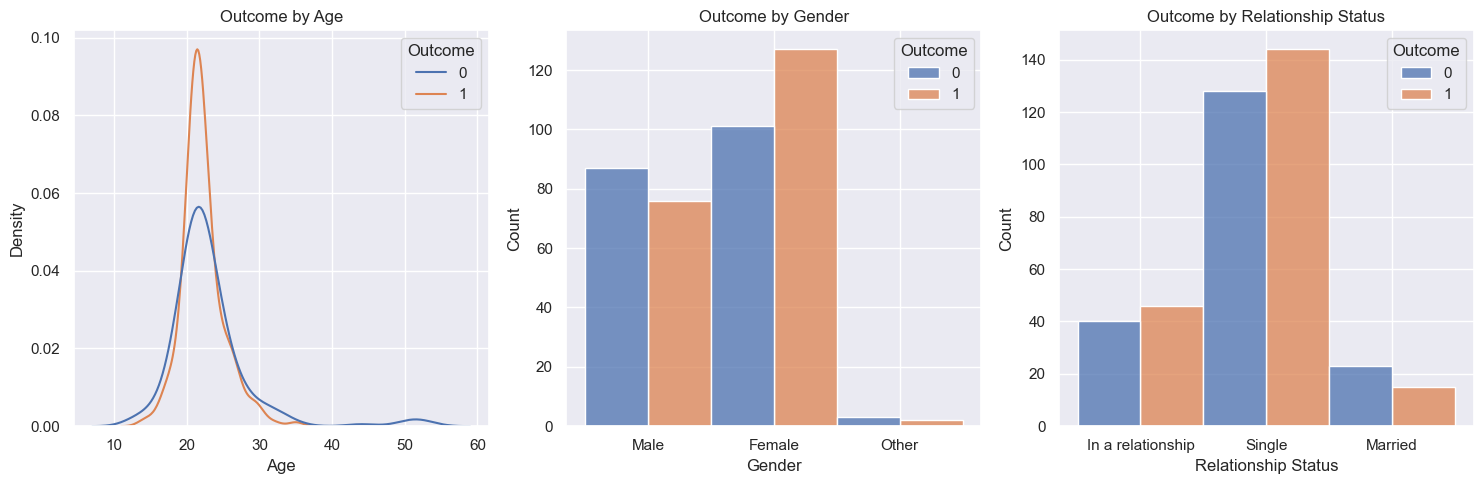

In [49]:
plt.figure(figsize=(15, 5))

# Subplot 1: Outcomes across different age groups
plt.subplot(1, 3, 1)
sns.kdeplot(x=data['Age'], 
            hue=data['Outcome'], 
            data=data).set_title('Outcome by Age')

# Subplot 2: Outcomes across different genders
plt.subplot(1, 3, 2)
sns.histplot(x=data['Gender'], 
             hue=data['Outcome'], multiple='dodge', 
             data=data).set_title('Outcome by Gender')

# Subplot 3: Outcomes across different relationship statuses
plt.subplot(1, 3, 3)
sns.histplot(x=data['Relationship Status'], 
             hue=data['Outcome'], multiple='dodge', 
             data=data).set_title('Outcome by Relationship Status')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Relationships between mental health scores and social media usage

Now that we know that our data is normally distributed, we can visualise whether a relationship exists between time spent on social media and mental health scores.

Pearson Correlation Coefficient for time spent on social media and mental health scores is r= 0.3453730111371367 p= 1.5512760544613927e-12
Pearson Correlation Coefficient for platform count and mental health scores is r= 0.13021098529658023 p= 0.009485893252291983


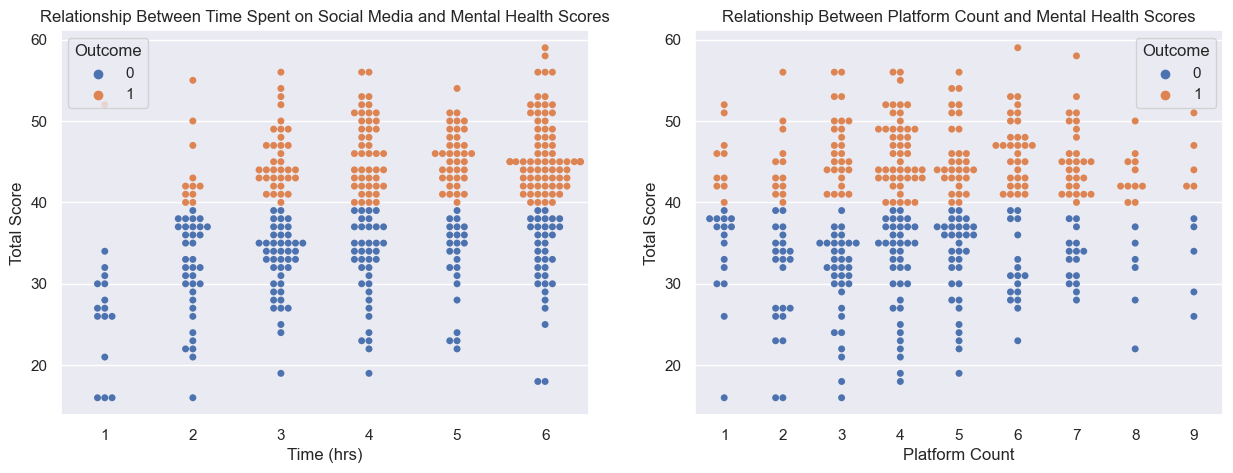

In [90]:
#Plot time spent on social media versus mental health scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.swarmplot(
    data=data, x=data['Time (hrs)'], y=data['Total Score'], hue=data['Outcome']).set(
        title='Relationship Between Time Spent on Social Media and Mental Health Scores')
    
plt.subplot(1, 2, 2)
sns.swarmplot(
    data=data, x=data['Platform Count'], 
    y=data['Total Score'], hue= data['Outcome']).set(
        title='Relationship Between Platform Count and Mental Health Scores')

#Using Pearson's Coefficient to determine whether this really is a linear relationship
pcoeff = stats.pearsonr(data['Time (hrs)'], 
                        data['Total Score'])
print('Pearson Correlation Coefficient for time spent on social media and mental health scores is r=', 
      pcoeff.statistic, 
      'p=', 
      pcoeff.pvalue)

pcoeff = stats.pearsonr(data['Platform Count'], 
                        data['Total Score'])
print('Pearson Correlation Coefficient for platform count and mental health scores is r=', 
      pcoeff.statistic, 
      'p=', 
      pcoeff.pvalue)

We have a positive, linear relationship between the time spent on social media and total mental health scores that is statistiscally significant.

Let's do a correlation of our data.

In [51]:
#Ok lets get correlations for mental health scores and our data. 
#First step, we need to convert string indices into integers, starting with Gender
data.loc[data['Gender'] == 'Male', 'Gender'] = 0
data.loc[data['Gender'] == 'Female', 'Gender'] = 1
data.loc[data['Gender'] == 'Other', 'Gender'] = 2
data['Gender'] = data['Gender'].astype('int64')

#Same for relationship status:
data.loc[data['Relationship Status'] == 'Single', 'Relationship Status'] = 0
data.loc[data['Relationship Status'] == 'Married', 'Relationship Status'] = 1
data.loc[data['Relationship Status'] == 'In a relationship', 'Relationship Status'] = 2
data.loc[data['Relationship Status'] == 'Divorced', 'Relationship Status'] = 3
data['Relationship Status'] = data['Relationship Status'].astype('int64')

#uncomment below to check values are correct
#data.head()

In [52]:
#dropping unecessary data - using the total questionnaire scores for each parameter.
data.drop(labels=['Anxiety Q1', 'Anxiety Q2', 
                    'Attention Q1', 'Attention Q2', 'Attention Q3', 'Attention Q4',
                    'Depression Q1', 'Depression Q2', 'Depression Q3', 
                    'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3'], axis=1, inplace=True)

## Correlation heatmap between variables

[Text(0.5, 1.0, 'Correlation Heatmap')]

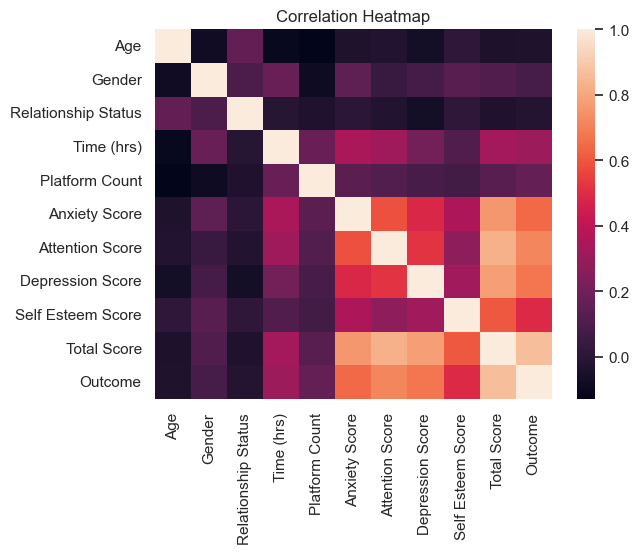

In [53]:
#create a correlation table using only numeric values in our data
corrdf = data.corr(method='spearman', numeric_only=True)
corrdf.sort_index(axis=1, ascending=True)

#visualise correlation coefficients in a heatmap
sns.heatmap(corrdf).set(title="Correlation Heatmap")

From the heatmap, and from the correlation table generated, we can conclude that Time Spent on social media has the strongest association with anxiety scores as well as total scores. Interestingly, total self esteem and depression scores didn't seem to have as strong a correlation with time spent on social media as the total anxiety and attention scores did.

## Conclusions and Summary